# Geospatial Analysis 

In [136]:
import pandas as pd
import numpy as np
import os
import folium
import json
import geopandas as gpd
import matplotlib.pyplot as plt

In [137]:
path = r'C:\Users\chris\Documents\airbnb_Berlin'
df_listings = pd.read_csv(os.path.join(path,'02 data', 'prepared data', 'listings_details_wrangled.csv'))
file_path = os.path.join(path, '02 data', 'original data', 'berlin-districts_oe.geojson')
gdf_geojson = gpd.read_file(file_path)
print(gdf_geojson.head())

                                     district        district_group  \
0             Blankenfelde/Niederschoenhausen                Pankow   
1                              Helmholtzplatz                Pankow   
2                          Wiesbadener Straße  Charlottenburg-Wilm.   
3  Schmoeckwitz/Karolinenhof/Rauchfangswerder   Treptow - Koepenick   
4                                  Müggelheim   Treptow - Koepenick   

   median_price                                           geometry  
0          37.5  MULTIPOLYGON (((1493006.880 6912074.798, 14929...  
1          58.0  MULTIPOLYGON (((1493245.549 6900059.696, 14932...  
2          50.0  MULTIPOLYGON (((1481381.452 6885170.698, 14813...  
3          99.0  MULTIPOLYGON (((1526159.829 6872101.044, 15261...  
4          25.0  MULTIPOLYGON (((1529265.086 6874326.842, 15292...  


Please note: Since there where issues with the geojson provided by inside airbnb, and I needed a functioning shapefile for my visualization, I searched Github and found another geojson file. https://github.com/adivicco47/Spatialstatistics/tree/master/Data

In [138]:
df_listings.head()

,id,scrape_id,last_scraped,source,host_id,host_location,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,...,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,host_location_cleansed,city,country,Price category
0,3176,20230622195229,2023-06-23,previous scrape,3718,"Coledale, Australia",Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,...,63,184,148,4.63,1,0.87,"Coledale, Australia",Coledale,Australia,Middle price
1,9991,20230622195229,2023-06-23,city scrape,33852,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53269,13.41805,...,6,14,8,5.00,1,0.08,"Berlin, Germany",Berlin,Germany,High price
2,14325,20230622195229,2023-06-23,city scrape,55531,"Berlin, Germany",Prenzlauer Berg Nordwest,Pankow,52.54813,13.40366,...,93,1125,26,4.67,4,0.16,"Berlin, Germany",Berlin,Germany,Low price
3,16644,20230622195229,2023-06-23,city scrape,64696,"Santa Cruz, CA",nördliche Luisenstadt,Friedrichshain-Kreuzberg,52.50312,13.43508,...,93,365,48,4.72,2,0.30,"Santa Cruz, CA",Santa Cruz,CA,Middle price
4,17904,20230622195229,2023-06-23,city scrape,68997,"Rio de Janeiro, Brazil",Reuterstraße,Neukölln,52.49419,13.42166,...,92,365,299,4.77,1,1.84,"Rio de Janeiro, Brazil",Rio de Janeiro,Brazil,Low price


In [139]:
df_listings.columns

Index(['id', 'scrape_id', 'last_scraped', 'source', 'host_id', 'host_location',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'price',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'calculated_host_listings_count',
       'reviews_per_month', 'host_location_cleansed', 'city', 'country',
       'Price category'],
      dtype='object')

### Cleaning and preparing for mapping

In [140]:
df_listings['neighbourhood_group_cleansed'].value_counts(dropna=False)

Mitte                       2728
Friedrichshain-Kreuzberg    2688
Pankow                      1959
Neukölln                    1484
Charlottenburg-Wilm.        1158
Tempelhof - Schöneberg       880
Treptow - Köpenick           491
Lichtenberg                  343
Steglitz - Zehlendorf        296
Reinickendorf                186
Spandau                      144
Marzahn - Hellersdorf         97
Name: neighbourhood_group_cleansed, dtype: int64

In [141]:
# getting rid of 'ö' and turn it into 'oe', to avoid problems with mapping (Did that with Replace in the geoJSON as well)
# For-Loop for correcting the values
result = []  

for value in df_listings["neighbourhood_group_cleansed"]:
    if value == 'Neukölln':
        result.append('Neukoelln')  
    elif value == 'Tempelhof - Schöneberg':
        result.append('Tempelhof - Schoeneberg')  
    elif value == 'Treptow - Köpenick':
        result.append('Treptow - Koepenick')  
    else:
        result.append(value)


df_listings["neighbourhood_group_cleansed"] = result

In [142]:
df_listings['neighbourhood_group_cleansed'].value_counts(dropna=False)

Mitte                       2728
Friedrichshain-Kreuzberg    2688
Pankow                      1959
Neukoelln                   1484
Charlottenburg-Wilm.        1158
Tempelhof - Schoeneberg      880
Treptow - Koepenick          491
Lichtenberg                  343
Steglitz - Zehlendorf        296
Reinickendorf                186
Spandau                      144
Marzahn - Hellersdorf         97
Name: neighbourhood_group_cleansed, dtype: int64

In [143]:
# Rename column to match the geoJSON
df_listings.rename(columns={'neighbourhood_group_cleansed': 'district_group'}, inplace=True)

In [144]:
df_listings['district_group'].value_counts(dropna=False)

Mitte                       2728
Friedrichshain-Kreuzberg    2688
Pankow                      1959
Neukoelln                   1484
Charlottenburg-Wilm.        1158
Tempelhof - Schoeneberg      880
Treptow - Koepenick          491
Lichtenberg                  343
Steglitz - Zehlendorf        296
Reinickendorf                186
Spandau                      144
Marzahn - Hellersdorf         97
Name: district_group, dtype: int64

In [145]:
# we want to see the average price on the map, hence we add this column to the sub:
df_listings['price_mean'] = df_listings.groupby(['district_group'])['price'].transform(np.mean)

## Creating a map

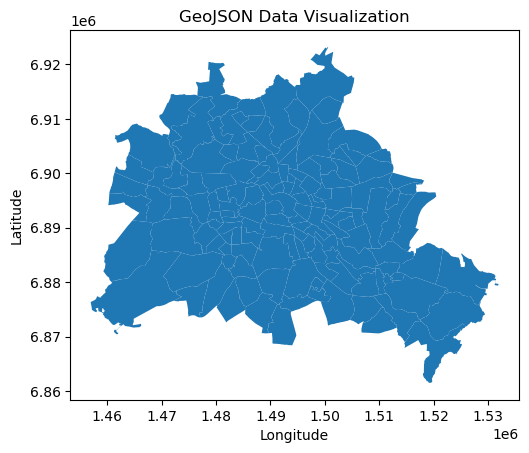

In [146]:
# Plot des GeoDataFrames # checking if displayed correctly
gdf_geojson.plot()
plt.title("GeoJSON Data Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [147]:
# Create a map
m = folium.Map(location=[52.5145, 13.3501], zoom_start=10)
# Füge das GeoJSON-Datenobjekt zur Karte hinzu
folium.GeoJson(gdf_geojson).add_to(m)
m

In [148]:
# Step 1: Grouping and averaging price by district
average_prices = df_listings.groupby('district_group')['price_mean'].mean().reset_index()

In [149]:
average_prices['district_group'].value_counts(dropna=False)

Charlottenburg-Wilm.        1
Friedrichshain-Kreuzberg    1
Lichtenberg                 1
Marzahn - Hellersdorf       1
Mitte                       1
Neukoelln                   1
Pankow                      1
Reinickendorf               1
Spandau                     1
Steglitz - Zehlendorf       1
Tempelhof - Schoeneberg     1
Treptow - Koepenick         1
Name: district_group, dtype: int64

In [150]:
# Step 2: Add the average prices to the geojson
gdf_geojson = gdf_geojson.merge(average_prices, left_on='district_group', right_on='district_group', how='left')

In [151]:
# Step 3: map it
m = folium.Map(location=[52.5145, 13.3501], zoom_start=10)

In [152]:
# Create the choropleth
folium.Choropleth(
    geo_data=gdf_geojson,
    name='choropleth',
    data=average_prices,
    columns=['district_group', 'price_mean'],
    key_on='feature.properties.district_group',
    fill_color='YlOrRd',  # Farbschema (hier: Gelb-Grün-Blau)
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Durchschnittlicher Preis pro Stadtbezirk'
).add_to(m)

# Show map
m

In [153]:
# Create a dataframe with average prices
average_prices_table = average_prices.set_index('district_group')

In [154]:
average_prices_table.head(15)

,price_mean
district_group,
Charlottenburg-Wilm.,116.372193
Friedrichshain-Kreuzberg,110.220610
Lichtenberg,92.023324
Marzahn - Hellersdorf,79.835052
Mitte,136.138196
Neukoelln,81.515499
Pankow,118.516590
Reinickendorf,74.403226
Spandau,100.729167
